In [ ]:
pip install Pillow

In [ ]:
pip install scipy==1.1.0

In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import os, os.path
from scipy import misc
import glob
import sys
from matplotlib.pyplot import imshow
import imageio
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import optimize
import random
import warnings
warnings.filterwarnings('ignore')
# np.seterr(all='raise');


initial image


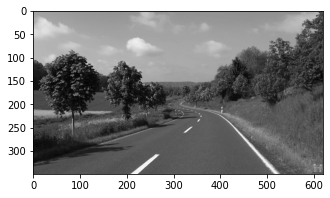

In [ ]:
path = "test2-mini.jpg"
arr = misc.imread(path, flatten=True)
print ("initial image")
imshow(arr, cmap='gray');

In [ ]:
tmp = plt.gcf().clear()

<Figure size 1440x216 with 0 Axes>

In [ ]:
initial_probability =  {"Sky.jpg": 0.30,"Road.jpg": 0.20, "Grass.jpg":0.50}
number_of_pixels = arr.size
class_info = []
paths= ["Sky.jpg", "Road.jpg", "Grass.jpg"]
for path in paths:
    tmp_arr = misc.imread(path, flatten=True)
    class_mean = np.mean(tmp_arr)
    class_var = np.var(tmp_arr)
    class_freq = len(tmp_arr)
    class_probabilty = class_freq/number_of_pixels
    class_info.append([initial_probability[path], class_mean, class_var])

print ("class_info")
print (class_info)

class_info
[[0.3, 166.92361, 272.364], [0.2, 95.18236, 964.224], [0.5, 59.97941, 1128.2644]]


In [ ]:
def pdf_of_normal(x, mean, var):
    return (1/np.sqrt(2 *  np.pi * var))*np.exp(-((x-mean)**2)/(2*var))

In [ ]:
def naive_bayes_predict (arr, class_info, fixed_pixels_index=[], correct_arr = []):
    predict_array = np.zeros((len(arr), len(arr[0])), dtype=float)
    class_color = [0,127,255]
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])): 
            if (len(fixed_pixels_index)>0 and len(correct_arr)>0 and fixed_pixels_index[i][j]==1):
                predict_array[i][j]=correct_arr[i][j]
                continue
            max_probabilty = 0
            best_class = -1
            val = arr[i][j]
            for cls_index in range(len(class_info)):
                cls_p =  class_info[cls_index][0]
                mean =  class_info[cls_index][1]
                var = class_info[cls_index][2]
                pos =pdf_of_normal(val, mean, var)
                cls_posterior = cls_p * pos

                if (cls_posterior > max_probabilty):
                    max_probabilty = cls_posterior
                    best_class = cls_index
            
            predict_array[i][j] = class_color[best_class]
            
    return predict_array

In [ ]:
def distance (x,y):
    a = x-y
    a = a*a
    return np.sqrt(np.sum(a))

In [ ]:
def differnce(a,b):
    if (a==b):
        return -1
    else:
        return 1

In [ ]:
def initial_energy_function(initial_w, pixels, betha, cls_info, neighbors_indices):
    w = initial_w
    energy = 0.0
    rows = len(w)
    cols = len(w[0])
    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            mean = cls_info[int (w[i][j])][1]
            var =  cls_info[int (w[i][j])][2]
            energy += np.log(np.sqrt(2*np.pi*var)) 
            energy += ((pixels[i][j]-mean)**2)/(2*var)
            for a,b in neighbors_indices:
                a +=i
                b +=j
                if 0<=a<rows and 0<=b<cols:
                    energy += betha * differnce(w[i][j], w[a][b])
    return energy

In [ ]:
def exponential_schedule(step_number, current_t, initial_temp,  constant=0.99):
    return current_t*constant
def logarithmical_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * np.log(1+step_number))
def linear_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * step_number)

In [ ]:
def delta_enegry(w, index, betha, new_value, neighbors_indices, pixels, cls_info):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    cols = len(w[0])
    mean = cls_info[int(w[i][j])][1]
    var =  cls_info[int(w[i][j])][2]
    initial_energy += np.log(np.sqrt(2*np.pi*var)) 
    initial_energy += ((pixels[i][j]-mean)**2)/(2*var)
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            initial_energy += betha * differnce(w[i][j], w[a][b])
    
    new_energy = 0
    mean = cls_info[new_value][1]
    var =  cls_info[new_value][2]
    new_energy += np.log(np.sqrt(2*np.pi*var)) 
    new_energy += ((pixels[i][j]-mean)**2)/(2*var)
    # print("/////// \n first enegry", new_energy)

    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            new_energy += betha * differnce(new_value, w[a][b])

    # print ("END energy", new_energy)

    return new_energy - initial_energy

In [ ]:
def simulated_annealing(init_w, class_labels, temprature_function,
                        pixels, betha, cls_info, neighbors_indices, max_iteration=10000,
                        initial_temp = 1000, known_index=[], correct_arr = [], temprature_function_constant=None ):
    partial_prediction=False
    if (len(known_index)>0 and len(correct_arr)>0):
        partial_prediction=True

    w = np.array(init_w)
    changed_array = np.zeros((len(w), len(w[0])))
    iteration =0
    x = len(w)
    y = len(w[0])
    current_energy = initial_energy_function(w, pixels, betha, cls_info, neighbors_indices)
    current_tmp = initial_temp
    while (iteration<max_iteration):
        if (partial_prediction):
            is_found=False
            while (is_found==False):
                i = random.randint(0, x-1)
                j = random.randint(0, y-1)
                if (known_index[i][j]==0):
                    is_found=True
        else:
            i = random.randint(0, x-1)
            j = random.randint(0, y-1)

        l = list(class_labels)
        l.remove(w[i][j])
        r = random.randint(0, len(l)-1)
        new_value = l[r]
        delta = delta_enegry(w, (i,j), betha, new_value, neighbors_indices, pixels, cls_info)

        r = random.uniform(0, 1)

        if (delta<=0):
            w[i][j]=new_value
            current_energy+=delta
            changed_array[i][j]+=1
            # print ("CHANGED better")
        else:
            try:
                if (-delta / current_tmp < -600):
                    k=0
                else:
                    k = np.exp(-delta / current_tmp)
            except:
                k=0

            if r < k:
                # print("CHANGED worse")
                w[i][j] = new_value
                current_energy += delta
                changed_array[i][j] += 1
        if (temprature_function_constant!=None):
            current_tmp = temprature_function(iteration, current_tmp, initial_temp, constant =temprature_function_constant)
        else:
            current_tmp = temprature_function(iteration, current_tmp, initial_temp)
        iteration+=1
    return w, changed_array

In [ ]:
def convert_to_class_labels(arr, inverse_array={0:0, 127:1, 255:2}):
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            arr[i][j] = inverse_array[int(arr[i][j])]

In [ ]:
def get_accuracy(arr, labels):
    correct = 0
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            if (labels[i][j]==int(arr[i][j]/127)):
                correct+=1
    return correct/(len(arr[0])*len(arr))

In [ ]:
# plt.close('all')
def a_complete_set_for_part_2 (arr, class_info, max_iter=1000000,var = 10000,
                               betha = 100,
                               neighbor_indices = [[0,1],[0,-1],[1,0],[-1,0]],
                               class_labels = [0,1,2], 
                               class_color = [0,127,255], 
                               schedule= exponential_schedule,
                               temprature_function_constant=None):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#     fig.suptitle('Comparision', fontsize=20)
    

    ax1.set_title("initial image")

    ax1.imshow(arr, cmap='gray')


    rows = len(arr)
    cols = len(arr[0])

#     cls_info = naive_bayes_learning(arr, noisy_arr, labels)
    cls_info = class_info
    initial_arr = naive_bayes_predict(arr, cls_info)
    ax2.set_title('Naive Bayes image')
    ax2.imshow(initial_arr, cmap='gray')

    convert_to_class_labels(initial_arr)
    
    w, test_array = simulated_annealing(initial_arr, class_labels, schedule,
                                        arr, betha, cls_info, neighbor_indices, max_iteration=max_iter)

    
    for i in range (0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = class_color[int (w[i][j])]

    ax3.set_title('CRF image')
    ax3.imshow(w, cmap='gray')
    plt.rcParams["figure.figsize"] = (20,3)
    ax4.set_title('differ image')

    ax4.imshow(test_array, cmap='gray')

    
    plt.show()

In [ ]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')

<Figure size 1280x1440 with 0 Axes>

<Figure size 1280x1440 with 0 Axes>

<Figure size 1280x1440 with 0 Axes>

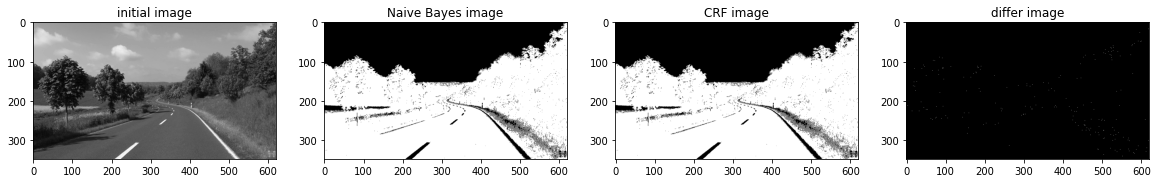

In [ ]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')
a_complete_set_for_part_2(arr,class_info, max_iter=1e4, betha=1e4)

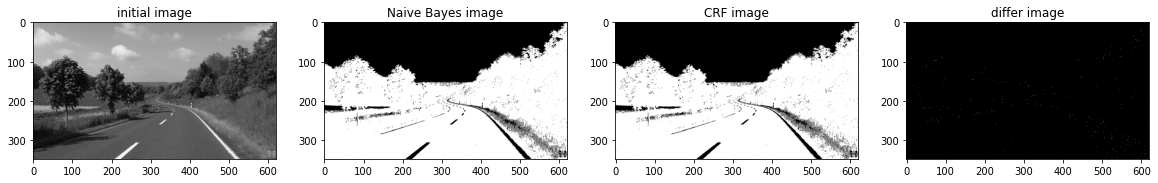

In [ ]:
a_complete_set_for_part_2(arr,class_info, max_iter=1e4, betha=1e6)

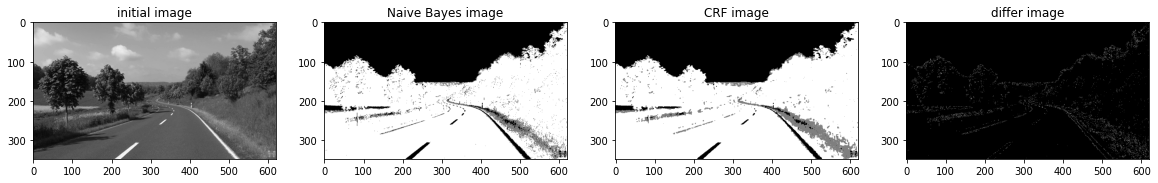

In [ ]:
a_complete_set_for_part_2(arr,class_info, max_iter=1e6, betha=1e6)

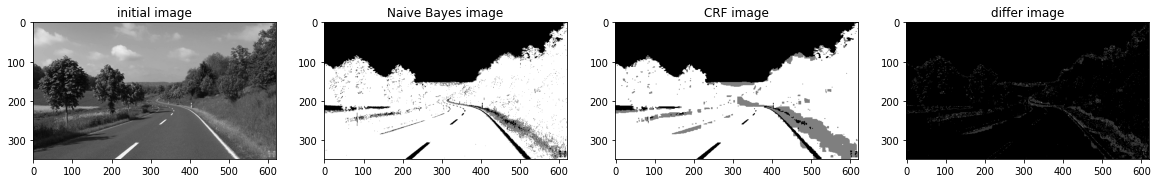

In [ ]:
a_complete_set_for_part_2(arr,class_info, max_iter=1e7, betha=1e6)

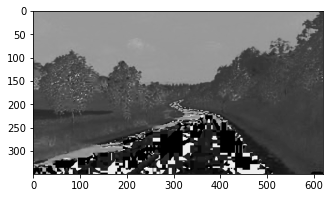

In [ ]:
import matplotlib
path = "test2-mini.jpg"
img = Image.open(path)
hsv_arr = matplotlib.colors.rgb_to_hsv(img)
hsv_arr = np.asarray(hsv_arr)
h_arr = hsv_arr[:,:,0]
plt.imshow(h_arr, cmap="gray")
plt.show()

In [ ]:
def read_image_h(path):
    img = Image.open(path)
    hsv_arr = matplotlib.colors.rgb_to_hsv(img)
    hsv_arr = np.asarray(hsv_arr)
    h_arr = hsv_arr[:,:,0]
#     plt.imshow(h_arr, cmap="gray")
#     plt.show()
    return 256*h_arr

In [ ]:
initial_probability = {"Sky.jpg": 0.30,"Road.jpg": 0.20, "Grass.jpg":0.50}
number_of_pixels = arr.size
class_info = []
paths= ["Sky.jpg", "Road.jpg", "Grass.jpg"]
for path in paths:
    tmp_arr = read_image_h(path)
    class_mean = np.mean(tmp_arr)
    class_var = np.var(tmp_arr)
    class_freq = len(tmp_arr)
    class_probabilty = class_freq/number_of_pixels
    class_info.append([initial_probability[path], class_mean, class_var])

print ("class_info")
print (class_info)

class_info
[[0.3, 151.39041, 2.6179988], [0.2, 64.93362, 6850.9604], [0.5, 67.78984, 159.66528]]


In [ ]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')

<Figure size 1280x1440 with 0 Axes>

<Figure size 1280x1440 with 0 Axes>

In [ ]:
arr_h = read_image_h("test2-mini.jpg")

<Figure size 1280x1440 with 0 Axes>

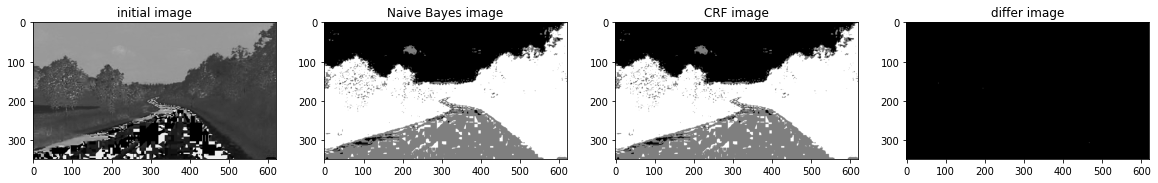

In [ ]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')
a_complete_set_for_part_2(arr_h,class_info, max_iter=1e2, betha=1e4)

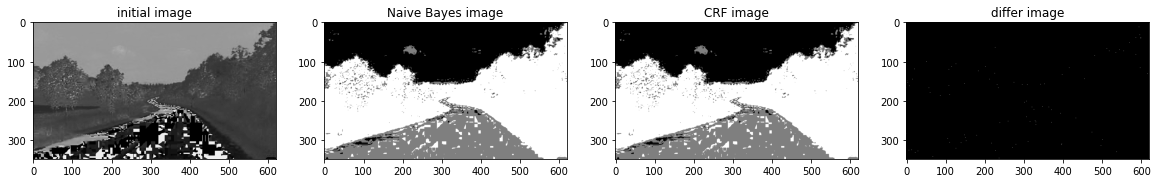

In [ ]:
a_complete_set_for_part_2(arr_h,class_info, max_iter=1e4, betha=1e4)

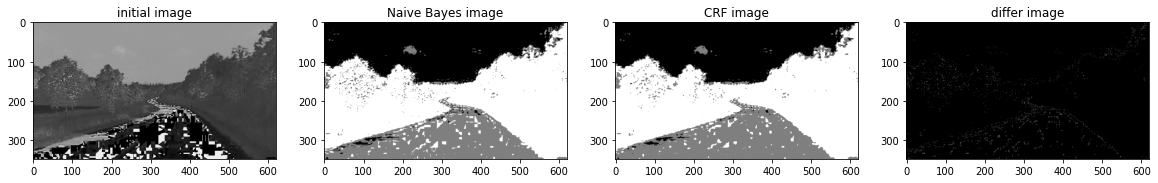

In [ ]:
a_complete_set_for_part_2(arr_h,class_info, max_iter=1e6, betha=1e4)

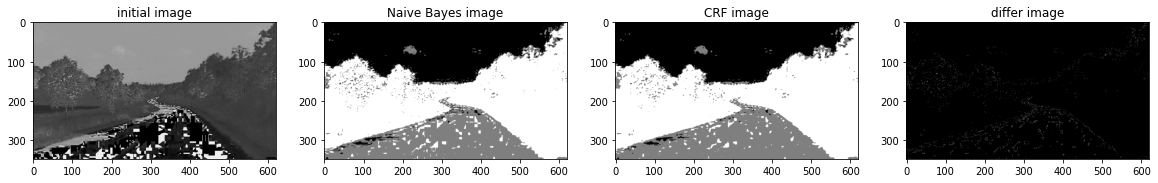

In [ ]:
a_complete_set_for_part_2(arr_h,class_info, max_iter=1e6, betha=1e6)

In [ ]:
def get_class_info_color(img_path, color_index,
                         paths=["Sky.jpg", "Road.jpg", "Grass.jpg"],
                         initial_probability={"Sky.jpg": 0.30,"Road.jpg": 0.20, "Grass.jpg":0.50}):
    arr_general = misc.imread(img_path)
    arr = arr_general[:,:,color_index]
    number_of_pixels = arr.size
    class_info = []
    paths= ["Sky.jpg", "Road.jpg", "Grass.jpg"]
    for path in paths:
        tmp_arr = misc.imread(path)
        tmp_arr = tmp_arr[:,:,color_index]
        class_mean = np.mean(tmp_arr)
        class_var = np.var(tmp_arr)
        class_freq = len(tmp_arr)
        # class_probabilty = class_freq/number_of_pixels
        class_info.append([initial_probability[path], class_mean, class_var])

    return class_info

In [ ]:
def naive_bayes_predict_3_color (arr, class_infos, fixed_pixels_index=[], correct_arr = []):
    predict_array = np.zeros((len(arr), len(arr[0])), dtype=float)
    class_color = [0,127,255]
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])): 
            if (len(fixed_pixels_index)>0 and len(correct_arr)>0 and fixed_pixels_index[i][j]==1):
                predict_array[i][j]=correct_arr[i][j]
                continue
            max_probabilty = 0
            best_class = -1
            
            for cls_index in range(0, len(class_color)):
                cls_posterior = class_infos[0][cls_index][0]
                for c in range(0, 3):#for RGB
                    val = arr[i][j][c]
                    class_info = class_infos[c]
                    mean =  class_info[cls_index][1]
                    var = class_info[cls_index][2]
                    pos =pdf_of_normal(val, mean, var)
                    cls_posterior *= pos
                    
                
                if (cls_posterior > max_probabilty):
                    max_probabilty = cls_posterior
                    best_class = cls_index     

            
            predict_array[i][j] = class_color[best_class]
            
    return predict_array

In [ ]:
def initial_energy_function_colored(initial_w, pixels, betha, cls_infos, neighbors_indices):
    w = initial_w
    energy = 0.0
    rows = len(w)
    cols = len(w[0])
    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            for c in [0,1,2]:
                cls_info = cls_infos[c]
                mean = cls_info[int (w[i][j])][1]
                var =  cls_info[int (w[i][j])][2]
                pixel_value = pixels[i][j][c]
                energy += np.log(np.sqrt(2*np.pi*var)) 
                energy += ((pixel_value-mean)**2)/(2*var)
            for a,b in neighbors_indices:
                a +=i
                b +=j
                if 0<=a<rows and 0<=b<cols:
                    energy += betha * differnce(w[i][j], w[a][b])
    return energy

In [ ]:
def delta_enegry_colored(w, index, betha, new_value, neighbors_indices, pixels, cls_infos):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    cols = len(w[0])
    for c in [0,1,2]:
        cls_info = cls_infos[c]
        mean = cls_info[int(w[i][j])][1]
        var =  cls_info[int(w[i][j])][2]
        pixel_value = pixels[i][j][c]
        initial_energy += np.log(np.sqrt(2*np.pi*var)) 
        initial_energy += ((pixel_value-mean)**2)/(2*var)
        
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            initial_energy += betha * differnce(w[i][j], w[a][b])
    
    new_energy = 0
    for c in [0,1,2]:
        cls_info = cls_infos[c]
        mean = cls_info[new_value][1]
        var =  cls_info[new_value][2]
        pixel_value = pixels[i][j][c]
        new_energy += np.log(np.sqrt(2*np.pi*var)) 
        new_energy += ((pixel_value-mean)**2)/(2*var)
    # print("/////// \n first enegry", new_energy)

    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            new_energy += betha * differnce(new_value, w[a][b])

    # print ("END energy", new_energy)

    return new_energy - initial_energy

In [ ]:
def simulated_annealing_colored(init_w, class_labels, temprature_function,
                        pixels, betha, cls_infos, neighbors_indices, max_iteration=10000,
                        initial_temp = 1000, known_index=[], correct_arr = [], temprature_function_constant=None ):
    partial_prediction=False
    if (len(known_index)>0 and len(correct_arr)>0):
        partial_prediction=True
    
    w = np.array(init_w)
    changed_array = np.zeros((len(w), len(w[0])))
    iteration =0
    x = len(w)
    y = len(w[0])
    current_energy = initial_energy_function_colored(w, pixels, betha, cls_infos, neighbors_indices)
    current_tmp = initial_temp
    while (iteration<max_iteration):
        if (partial_prediction):
            is_found=False
            while (is_found==False):
                i = random.randint(0, x-1)
                j = random.randint(0, y-1)
                if (known_index[i][j]==0):
                    is_found=True
        else:
            i = random.randint(0, x-1)
            j = random.randint(0, y-1)

        l = list(class_labels)
        l.remove(w[i][j])
        r = random.randint(0, len(l)-1)
        new_value = l[r]
        delta = delta_enegry_colored(w, (i,j), betha, new_value, neighbors_indices, pixels, cls_infos)

        r = random.uniform(0, 1)

        if (delta<=0):
            w[i][j]=new_value
            current_energy+=delta
            changed_array[i][j]+=1
            # print ("CHANGED better")
        else:
            try:
                if (-delta / current_tmp < -600):
                    k=0
                else:
                    k = np.exp(-delta / current_tmp)
            except:
                k=0

            if r < k:
                # print("CHANGED worse")
                w[i][j] = new_value
                current_energy += delta
                changed_array[i][j] += 1
        if (temprature_function_constant!=None):
            current_tmp = temprature_function(iteration, current_tmp, initial_temp, constant =temprature_function_constant)
        else:
            current_tmp = temprature_function(iteration, current_tmp, initial_temp)
        iteration+=1
    return w, changed_array

In [ ]:
def a_complete_set_for_part_2_3_color (max_iter=1000000, var = 10000,
                               betha = 100,
                               neighbor_indices = [[0,1],[0,-1],[1,0],[-1,0]],
                               class_labels = [0,1,2],
                               class_color = [0,127,255],
                               schedule= exponential_schedule,
                               temprature_function_constant=None,
                               image_path = "test2-mini.jpg"):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#     fig.suptitle('Comparision', fontsize=20)

    arr = misc.imread(image_path)
    ax1.set_title("initial image")

    ax1.imshow(arr)




#     cls_info = naive_bayes_learning(arr, noisy_arr, labels)
    cls_infos = []
    for c in [0,1,2]:
        tmp_info =get_class_info_color(image_path,c)
        cls_infos.append(tmp_info)


    initial_arr = naive_bayes_predict_3_color(arr, cls_infos)
    ax2.set_title('Naive Bayes image')
    ax2.imshow(initial_arr, cmap='gray')

    
    convert_to_class_labels(initial_arr)

    w, test_array = simulated_annealing_colored(initial_arr, class_labels, schedule,
                                        arr, betha, cls_infos, neighbor_indices, max_iteration=max_iter)


    for i in range (0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = class_color[int (w[i][j])]

    ax3.set_title('CRF image')
    ax3.imshow(w, cmap='gray')
    plt.rcParams["figure.figsize"] = (20,3)
    ax4.set_title('differ image')

    ax4.imshow(test_array, cmap='gray')

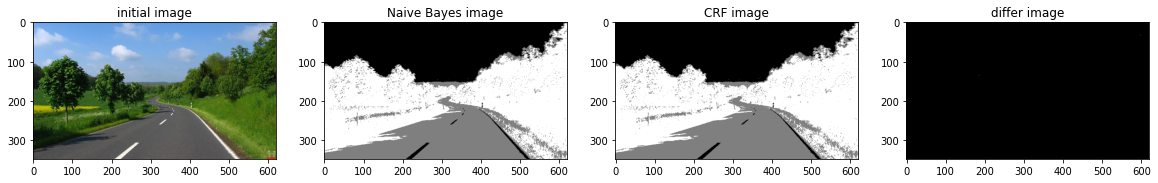

In [ ]:
a_complete_set_for_part_2_3_color(max_iter=1e2, betha=1e4)

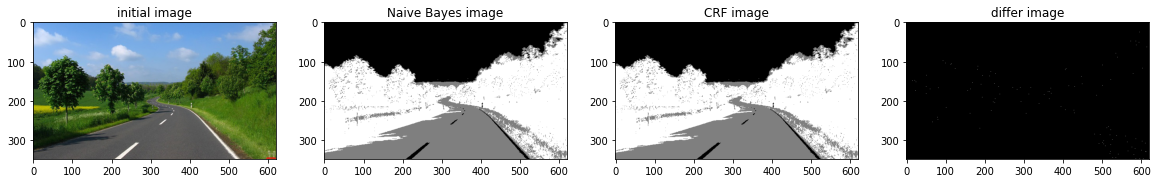

In [ ]:
a_complete_set_for_part_2_3_color(max_iter=1e4, betha=1e4)

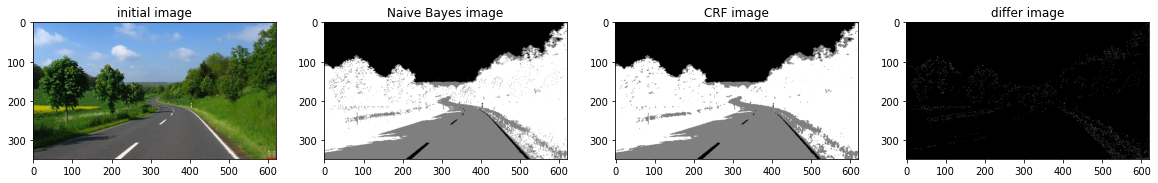

In [ ]:
a_complete_set_for_part_2_3_color(max_iter=1e6, betha=1e4)

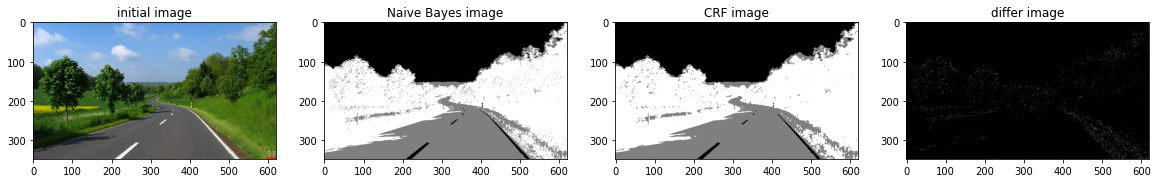

In [ ]:
a_complete_set_for_part_2_3_color(max_iter=1e6, betha=1e6)

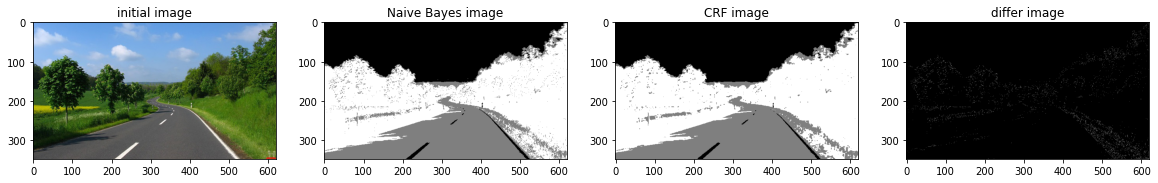

In [ ]:
a_complete_set_for_part_2_3_color(max_iter=1e6, betha=1e6,
                                 schedule=linear_multiplicative_cooling_schedule, temprature_function_constant=0.5)

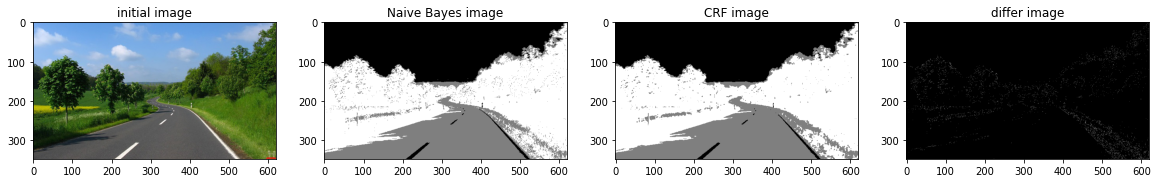

In [ ]:
np.seterr(all='raise');
a_complete_set_for_part_2_3_color(max_iter=1e6, betha=1e6,
                                 schedule=linear_multiplicative_cooling_schedule, temprature_function_constant=0.5)